In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append('../')

from model.LP import LP
from model.DeepLP import DeepLP
from model.DeepLP_RBF import DeepLP_RBF
from model.DeepLP_WeightedRBF import DeepLP_WeightedRBF
from model.DeepLP_RBF_Sparse import DeepLP_RBF_Sparse
from model.DeepLP_WeightedRBF_Sparse import DeepLP_WeightedRBF_Sparse

from model.utils import *

label_prob = 0.05
hard = True
percentile = 5

sigma = 3
theta = np.array([ 1 ,  1,  1,  1 ])

%matplotlib inline

### Iris Data

In [193]:

# get labels, features and weights
# load iris data
iris   = datasets.load_iris()
data   = iris["data"]
labels = iris["target"]

# get label 0 and 1, and corresponding data
labels = labels[labels < 2].astype(float)
features = data[np.where(labels < 2)]

is_labeled, labels = random_unlabel(labels,label_prob=label_prob,hard=hard)

### Cora Data

### Data Preparation

In [194]:
def random_unlabel(labels,label_prob=0.1,hard=False):

    is_labeled = np.zeros(num_nodes)
    is_labeled.fill(True)
    n = is_labeled.size
    

    random_indices = np.random.choice(n, int(n * label_prob), replace=False)
    is_labeled.ravel()[random_indices] = False
    labels[random_indices] = 0.5

    return is_labeled, labels

In [4]:
mask, labels = random_unlabel(data,labels,label_prob=label_prob,hard=hard)
features = np.vstack((LX,UX))
weights = rbf_kernel(features,s=sigma,percentile=percentile)

true_labels = np.hstack((Ly,Uy_sol))
num_features = features.shape[1]
num_labeled = len(Ly)
num_unlabeled = len(Uy)
num_nodes = num_labeled+num_unlabeled

graph = (weights > 0).astype(int)

In [5]:
random_unlabeled_points

array([ True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [4]:
# prepare features for NN
LY = np.tile(Ly,(Ly.shape[0],1))
np.fill_diagonal(LY, 0.5)
UY = np.tile(Uy,(Ly.shape[0],1))

masked_ = np.hstack((np.identity(LY.shape[0]),np.zeros((Ly.shape[0],Uy.shape[0]))))
true_labeled = np.array([1] * LY.shape[0] + [0] * Uy.shape[0]).reshape(1,num_nodes)

In [5]:
unlabeled_test = np.hstack((np.zeros(LY.shape[0]),np.ones((Uy.shape[0])))).reshape(1,num_nodes)
test_data = {
    'X': np.hstack((Ly,Uy)).reshape(1,num_nodes),
    'y': np.tile(true_labels,(Ly.shape[0],1))[1:2],
    'unlabeled': unlabeled_test,
    'labeled': (1 - unlabeled_test).reshape(1,num_nodes),
    'true_labeled': true_labeled,
    'masked':masked_[0:1]
}

In [6]:
unlabeled_ = np.hstack((np.identity(LY.shape[0]),np.ones((Ly.shape[0],Uy.shape[0]))))
data = {
    'X':np.hstack((LY, UY)),
    'y':np.reshape(true_labels,(1,len(true_labels))),
    'unlabeled':unlabeled_,
    'labeled':1-unlabeled_,
    'true_labeled': true_labeled,
    'masked':masked_
}

# Label Propagation

In [80]:
lp = LP(num_nodes,num_labeled)
Uy_lp = np.rint(lp.closed(weights,Ly))
Uy_lp_iter = np.squeeze(np.rint(lp.iter_(weights,Ly,Uy,100)))

In [81]:
print("[Accuracy] Closed solution:", accuracy(Uy_sol, Uy_lp), " Iter Solution:", accuracy(Uy_sol, Uy_lp_iter))
print("[RMSE] Closed solution", rmse(Uy_sol, Uy_lp), " Iter solution", rmse(Uy_sol, Uy_lp_iter))

[Accuracy] Closed solution: 0.494736842105  Iter Solution: 0.494736842105
[RMSE] Closed solution 0.505263157895  Iter solution 0.505263157895


In [82]:
for iter_ in [1,2,3,4,5,10,100,1000]:
    print(iter_)
    Uy_lp_iter = np.squeeze(np.rint(lp.iter_(weights,Ly,Uy,iter_)))
    print("Objective:", objective(Ly,np.rint(Uy_lp_iter),weights))
    print("Accuracy:", accuracy(Uy_sol,Uy_lp_iter))
    print("RMSE:", rmse(Uy_sol,Uy_lp_iter))

1
Objective: 892.192943365
Accuracy: 0.0
RMSE: 1.0
2
Objective: 892.192943365
Accuracy: 0.0
RMSE: 1.0
3
Objective: 892.192943365
Accuracy: 0.0
RMSE: 1.0
4
Objective: 107.83742828
Accuracy: 0.494736842105
RMSE: 0.505263157895
5
Objective: 256.382415943
Accuracy: 0.536842105263
RMSE: 0.463157894737
10
Objective: 656.493162145
Accuracy: 0.673684210526
RMSE: 0.326315789474
100
Objective: 107.83742828
Accuracy: 0.494736842105
RMSE: 0.505263157895
1000
Objective: 107.83742828
Accuracy: 0.494736842105
RMSE: 0.505263157895


# DeepLP

In [83]:
dlp = DeepLP(100, num_nodes, weights, 1)

In [84]:
pred_dlp = dlp.labelprop(test_data)
Uy_dlp = np.rint(pred_dlp[:,num_labeled:]).reshape(num_unlabeled)

In [85]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp))
print("RMSE:", rmse(Uy_sol,Uy_dlp))
print("Objective:", objective(Ly,Uy_dlp,dlp.get_val(dlp.W)))

Accuracy: 0.494736842105
RMSE: 0.505263157895
Objective: 107.837448001


# DeepLP_RBF

In [86]:
dlp_rbf = DeepLP_RBF(100, num_nodes, features, graph, sigma, lr=0.01)

In [87]:
pred_dlp_rbf = dlp_rbf.labelprop(test_data)
Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)

In [88]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_rbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_rbf))
print("Objective:", objective(Ly,Uy_dlp_rbf,dlp_rbf.get_val(dlp_rbf.W)))

Accuracy: 0.494736842105
RMSE: 0.505263157895
Objective: 107.837469816


In [89]:
dlp_rbf.train(data,test_data,200)

epoch: -1 labeled loss: 0.331355 unlabeled loss: 0.244406 accuracy: 0.798 sol unlabeled loss: 0.224716 sol accuracy: 0.494737
--- 1.8873851299285889 seconds ---
epoch: 0 labeled loss: 0.331042 unlabeled loss: 0.244163 accuracy: 0.798 sol unlabeled loss: 0.224431 sol accuracy: 0.494737
--- 0.10510683059692383 seconds ---
sigma: 2.99
epoch: 10 labeled loss: 0.327641 unlabeled loss: 0.241519 accuracy: 0.798 sol unlabeled loss: 0.221342 sol accuracy: 0.494737
--- 0.6058540344238281 seconds ---
sigma: 2.88944
epoch: 20 labeled loss: 0.323597 unlabeled loss: 0.238381 accuracy: 0.798 sol unlabeled loss: 0.217686 sol accuracy: 0.494737
--- 0.6256229877471924 seconds ---
sigma: 2.78632
epoch: 30 labeled loss: 0.318644 unlabeled loss: 0.234545 accuracy: 0.798 sol unlabeled loss: 0.213232 sol accuracy: 0.494737
--- 0.610346794128418 seconds ---
sigma: 2.67864
epoch: 40 labeled loss: 0.312402 unlabeled loss: 0.229721 accuracy: 0.798 sol unlabeled loss: 0.207657 sol accuracy: 0.515789
--- 0.5978350

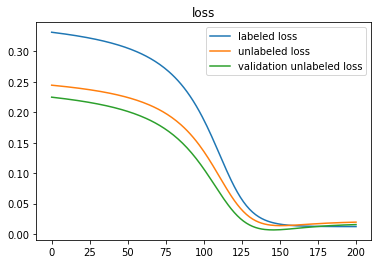

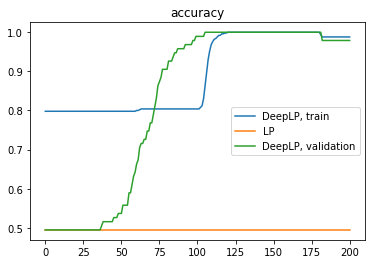

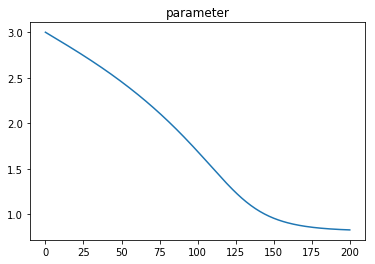

In [90]:
dlp_rbf.plot()

# DeepLP_WeightedRBF

In [91]:
dlp_wrbf = DeepLP_WeightedRBF(100, num_nodes, features, graph, 
                              sigma, theta, lr=0.01, regularize=0.1)

In [92]:
pred_dlp_wrbf = dlp_wrbf.labelprop(test_data)
Uy_dlp_wrbf = np.rint(pred_dlp_wrbf[:,num_labeled:]).reshape(num_unlabeled)

In [93]:
print("Accuracy:", accuracy(Uy_sol,Uy_dlp_wrbf))
print("RMSE:", rmse(Uy_sol,Uy_dlp_wrbf))
print("Objective:", objective(Ly,Uy_dlp_wrbf,dlp_wrbf.get_val(dlp_wrbf.W)))

Accuracy: 0.494736842105
RMSE: 0.505263157895
Objective: 107.837469816


In [96]:
dlp_wrbf.train(data,test_data,200)

epoch: -1 labeled loss: 0.331355 unlabeled loss: 0.244406 accuracy: 0.798 sol unlabeled loss: 0.224716 sol accuracy: 0.494737
--- 22.450119018554688 seconds ---
epoch: 0 labeled loss: 0.330415 unlabeled loss: 0.24367 accuracy: 0.798 sol unlabeled loss: 0.223867 sol accuracy: 0.494737
--- 0.11741518974304199 seconds ---
theta: [ 1.00999975  0.99000341  1.00999999  1.00999963]
epoch: 10 labeled loss: 0.321596 unlabeled loss: 0.235566 accuracy: 0.798 sol unlabeled loss: 0.214495 sol accuracy: 0.494737
--- 0.6180260181427002 seconds ---
theta: [ 1.10670173  0.99305969  1.11033475  1.10365522]
epoch: 20 labeled loss: 0.313215 unlabeled loss: 0.226442 accuracy: 0.798 sol unlabeled loss: 0.204016 sol accuracy: 0.536842
--- 0.5927200317382812 seconds ---
theta: [ 1.18375432  1.00163591  1.21228659  1.15955687]
epoch: 30 labeled loss: 0.304146 unlabeled loss: 0.216698 accuracy: 0.798 sol unlabeled loss: 0.192906 sol accuracy: 0.652632
--- 0.5754268169403076 seconds ---
theta: [ 1.2206676   1.00

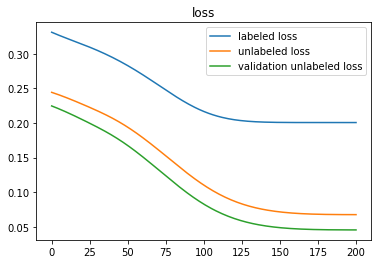

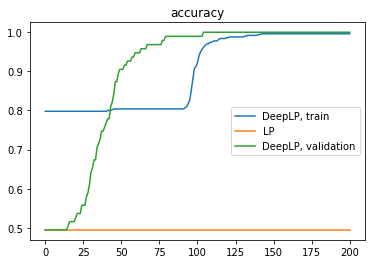

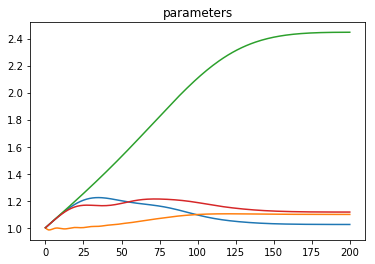

In [97]:
dlp_wrbf.plot()

In [101]:
sigmas = [i for i in np.arange(0.1,3,0.1)]

In [114]:
accuracies = []
rmses = []
objectives = []

for i,sigma_ in enumerate(sorted(sigmas)):
    print(i)
    if i % 50 == 0:
        print(i)
    dlp_rbf = DeepLP_RBF(100, num_nodes, features, graph, sigma_, lr=0.01)    
    pred_dlp_rbf = dlp_rbf.labelprop(test_data)
    Uy_dlp_rbf = np.rint(pred_dlp_rbf[:,num_labeled:]).reshape(num_unlabeled)

    accuracies.append(accuracy(Uy_sol,Uy_dlp_rbf))
    rmses.append(rmse(Uy_sol,Uy_dlp_rbf))
    objectives.append(objective(Ly,Uy_dlp_rbf,dlp_rbf.get_val(dlp_rbf.W)))


0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28


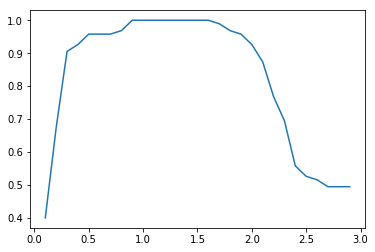

In [126]:
plt.plot(sigmas,accuracies)
plt.show()

In [8]:
accuracies = []
thetas = []
for i in range(100): 
    theta_ = np.random.uniform(0.5,3,4)
    if i % 10 == 0:
        print(i)
    test_data['theta'] = theta_.reshape(1,4)
    dlp_wrbf = DeepLP_WeightedRBF(100, num_nodes, features, graph, 
                              sigma, theta_, lr=0.01, regularize=0.1)
    pred_dlp_wrbf = dlp_wrbf.labelprop(test_data)
    Uy_dlp_wrbf = np.rint(pred_dlp_wrbf[:,num_labeled:]).reshape(num_unlabeled)
    accuracies.append(accuracy(Uy_sol,Uy_dlp_wrbf))
    thetas.append(theta_)

0
10
20
30
40
50
60
70
80
90


In [9]:
theta_df = pd.DataFrame(thetas)
accuracy_df = pd.DataFrame(accuracies)

theta_df.reset_index(drop=True, inplace=True)
accuracy_df.reset_index(drop=True, inplace=True)

df = pd.concat( [theta_df,accuracy_df], axis=1) 
df.columns = ['theta1','theta2','theta3','theta4','accuracy']

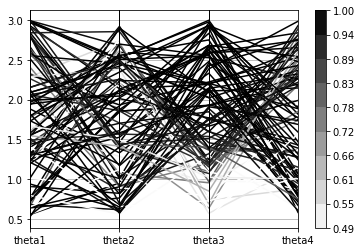

In [15]:
a = parallel_coordinates(df, 'accuracy', colormap="binary")